In [5]:
from sage.all import *




# def SQUFOF(N):
    
#     def get_Q_iplus1(Q_iminus1,b_i,P_iminus1,P_i):
#         return Q_iminus1+b_i*(P_iminus1-P_i)
    
#     def get_P_i(b_i,Q_i,P_iminus1):
#         return b_i*Q_i - P_iminus1
    
#     def get_reverse_P_i(b_i,Q_i,P_iminus1):
#         return b_i*sqrt(Q_i) - P_iminus1
    
#     x = sqrt(N)
#     b_k = floor(x)
#     P_k = b_k
#     Q_k = 1
#     Q_kk = (N - b_k^2)
#     Q_kkk = 2
#     P_kold = 2
#     index = 0
#     while (not Q_kkk.is_square()) or index%2 ==0:
        
#         #       |   Floor(Sqrt(N)) + P_(i-1)  |
#         # b_i = |  -------------------------- |
#         #       |_        Q_i                _|
        
#         b_kk = floor( (floor(sqrt(N)) + P_k) / Q_kk)
#         P_kk = get_P_i(b_kk,Q_kk,P_k)
#         Q_kkk = get_Q_iplus1(Q_k,b_kk,P_k,P_kk)
        
#         P_kold, P_k, Q_k, Q_kk = P_k, P_kk, Q_kk, Q_kkk
#         index += 1

    
#     b_k = floor( (floor(sqrt(N)) - P_k) / sqrt(Q_kk))
#     while not P_kold == P_k:
#         b_kk = floor( (floor(sqrt(N)) + P_k) / Q_kk)
#         P_kk = get_P_i(b_kk,Q_kk,P_k)
#         Q_kkk = get_Q_iplus1(Q_k,b_kk,P_k,P_kk)
        

#         P_kold, P_k, Q_k, Q_kk = P_k, P_kk, Q_kk, Q_kkk

#     return (gcd(N,P_k))
        

In [1]:
import random
import math
import time
import matplotlib.pyplot as plt
from sympy import primerange
import zipfile
from random import getrandbits

In [9]:


class SqufofAnalyzer:
    def __init__(self):
        print("init xd")
    def SQUFOF(self,N):
        multiplier = [1, 3, 5, 7, 11, 3*5, 3*7, 3*11, 5*7, 5*11, 7*11, 3*5*7, 3*5*11, 3*7*11, 5*7*11, 3*5*7*11]

        s = math.isqrt(N)
        if s * s == N:
            return s

        for k in range(len(multiplier)):
            if N <= 2**256 // multiplier[k]:
                D = multiplier[k] * N
                Po = Pprev = P = math.isqrt(D)
                Qprev = 1
                Q = D - Po * Po
                L = 2 * math.isqrt(2 * s)
                B = 3 * L
                for i in range(2, B):
                    b = (Po + P) // Q
                    P = b * Q - P
                    q = Q
                    Q = Qprev + b * (Pprev - P)
                    r = math.isqrt(Q)
                    if i % 2 == 0 and r * r == Q:
                        break
                    Qprev = q
                    Pprev = P
                else:
                    continue

                b = (Po - P) // r
                Pprev = P = b * r + P
                Qprev = r
                Q = (D - Pprev * Pprev) // Qprev
                i = 0
                while True:
                    b = (Po + P) // Q
                    Pprev = P
                    P = b * Q - P
                    q = Q
                    Q = Qprev + b * (Pprev - P)
                    Qprev = q
                    i += 1
                    if P == Pprev:
                        break

                r = gcd(N, Qprev)
                if r != 1 and r != N:
                    return r

        return 0
    
    def __read_primes_from_zip(self, zip_index):
        primes_list = []
        zip_file_name = f'primes{zip_index}.zip'
        file_name_inside_zip = f'primes{zip_index}.txt'

        with zipfile.ZipFile(zip_file_name, 'r') as z:
            with z.open(file_name_inside_zip) as file:
                i = 0
                for line in file:
                    # Skip the first 4 lines (headers)
                    if i < 4:
                        i += 1
                        continue

                    # Decode line (zip file contents are bytes)
                    line = line.decode('utf-8')

                    primes = line.split()
                    for prime in primes:
                        primes_list.append(int(prime))

        return primes_list
    
    def __process_composite_number(self,composite_number, batch_data, write_interval,method):      
        start_time = time.time()
        factor = self.SQUFOF(composite_number)  # Assuming SQUFOF is defined elsewhere
        end_time = time.time()

        time_elapsed = end_time - start_time

        if factor == 0:
            print("Squfof 0?")
            return false
        
        num_bits = composite_number.nbits()
        batch_data.append(f"{num_bits}, {time_elapsed}\n")
        if len(batch_data) >= write_interval:
            with open(method+'_squfof_data.txt', 'a') as file:
                file.writelines(batch_data)
            batch_data.clear()
            print("Written batch.")
        
        return true
            
    def __generate_random_composite(self,num_bits):
        # Generating random numbers until a composite of the desired bit length is found
        while True:
            # Generate a random number of the specified bit length
            number = getrandbits(num_bits)

            # Ensure it's odd (to increase the chance of being composite)
            number |= 1

            # Convert to Sage integer
            number = Integer(number)

            # Check if the number is not prime (hence, composite)
            if not is_prime(number):
                return number

            
    def collect_and_write_data(self,  method):
        num_bits_threshold = 20
        ctr_num_bits = 0
        prev_num_bits = 0
        write_interval = 1000  # Interval after which data is written to the file
        batch_data = []  # Temporary storage for data to be written in batches

        try:
            if method == "primes":
                for zip_index in range(1, 51): 
                    primes = self.__read_primes_from_zip(zip_index)
                    print(zip_index,len(batch_data))
                    for i in range(len(primes) - 1):

                        composite_number = primes[i] * primes[i + 1]
                        num_bits = composite_number.bit_length()
                        if num_bits != prev_num_bits:
                            prev_num_bits = num_bits
                            ctr_num_bits = 0
                        elif ctr_num_bits > num_bits_threshold:
                            continue
                        ctr_num_bits += 1

                        self.__process_composite_number(composite_number,batch_data,write_interval,method)
            elif method == "random":
                num_bits = 10
                while true:
                    if num_bits != prev_num_bits:
                        print(str(num_bits)+ " bit")
                        prev_num_bits = num_bits
                        ctr_num_bits = 0
                    elif ctr_num_bits > num_bits_threshold:
                        num_bits+=1
                        continue
                    ctr_num_bits += 1
                    composite_number=self.__generate_random_composite(num_bits)
                    while(not self.__process_composite_number(composite_number, batch_data, write_interval, method)):
                        composite_number=self.__generate_random_composite(num_bits)


        except KeyboardInterrupt:
            # Write remaining data to file on interruption
            with open(method+'squfof_data.txt', 'a') as file:
                file.writelines(batch_data)
            print("Data written to '"+method+"squfof_data.txt' on interruption")
        
        with open(method+'squfof_data.txt', 'a') as file:
            file.writelines(batch_data)
        print("Data written to '"+method+"squfof_data.txt' on end")



In [12]:
analyzer = SqufofAnalyzer()
analyzer.collect_and_write_data(method="random")

init xd
10 bit
11 bit
12 bit
13 bit
14 bit
15 bit
16 bit
17 bit
18 bit
19 bit
20 bit
21 bit
22 bit
23 bit
24 bit
25 bit
26 bit
27 bit
28 bit
29 bit
30 bit
31 bit
32 bit
33 bit
34 bit
35 bit
36 bit
37 bit
38 bit
39 bit
40 bit
41 bit
42 bit
43 bit
44 bit
45 bit
46 bit
47 bit
48 bit
49 bit
50 bit
51 bit
52 bit
53 bit
54 bit
55 bit
56 bit
57 bit
Written batch.
58 bit
59 bit
60 bit
61 bit
62 bit
63 bit
64 bit
65 bit
66 bit
67 bit
68 bit
69 bit
70 bit
71 bit
72 bit
73 bit
74 bit
75 bit
76 bit
77 bit
78 bit
79 bit
80 bit
81 bit
82 bit
83 bit
84 bit
85 bit
86 bit
87 bit
88 bit
89 bit
90 bit
91 bit
92 bit
93 bit
94 bit
95 bit
96 bit
97 bit
98 bit
99 bit
100 bit
101 bit
102 bit
103 bit
104 bit
105 bit
Written batch.
106 bit
107 bit
108 bit
109 bit
110 bit
111 bit
112 bit
113 bit
114 bit
115 bit
116 bit
117 bit
118 bit
119 bit
Data written to 'randomsqufof_data.txt' on interruption
Data written to 'randomsqufof_data.txt' on end


In [50]:



import time

def collect_and_write_data():
    num_bits_threshold = 20
    ctr_num_bits = 0
    prev_num_bits = 0
    write_interval = 1000  # Interval after which data is written to the file
    batch_data = []  # Temporary storage for data to be written in batches

    try:
        for zip_index in range(1, 51): 
            primes = read_primes_from_zip(zip_index)
            print(zip_index,len(batch_data))
            for i in range(len(primes) - 1):
                composite_number = primes[i] * primes[i + 1]
                num_bits = composite_number.bit_length()

                if num_bits != prev_num_bits:
                    prev_num_bits = num_bits
                    ctr_num_bits = 0
                elif ctr_num_bits > num_bits_threshold:
                    continue
                ctr_num_bits += 1

                start_time = time.time()
                factor = SQUFOF(composite_number)  # Assuming SQUFOF is defined
                end_time = time.time()

                time_elapsed = end_time - start_time
                #print(f"Number of Bits: {num_bits}, Number to Factor: {composite_number}, Factor found by SQUFOF: {factor}, Time Elapsed: {time_elapsed} seconds")
                if factor != 0:
                    batch_data.append(f"{num_bits}, {time_elapsed}\n")

                # Write data to file at regular intervals
                if len(batch_data) >= write_interval:
                    with open('squfof_data.txt', 'a') as file:
                        file.writelines(batch_data)
                    batch_data.clear()

    except KeyboardInterrupt:
        # Write remaining data to file on interruption
        with open('squfof_data.txt', 'a') as file:
            file.writelines(batch_data)
        print("Data written to 'squfof_data.txt' on interruption")

    # Write any remaining data and indicate the end of data collection
    with open('squfof_data.txt', 'a') as file:
        file.writelines(batch_data)
        file.write("END\n")
    print("Data collection completed and 'END' written to 'squfof_data.txt'")

# Make sure to define read_primes_from_zip and SQUFOF functions


def plot_data_from_file(filename):
    bit_lengths = []
    times = []

    with open(filename, 'r') as file:
        for line in file:
            num_bits, elapsed_time = line.strip().split(', ')
            bit_lengths.append(int(num_bits))
            times.append(float(elapsed_time))

    plt.scatter(bit_lengths, times)
    plt.title("SQUFOF Algorithm Time Complexity")
    plt.xlabel("Number of Bits")
    plt.ylabel("Time (seconds)")
    plt.show()

# Run the data collection

# To plot data later from the file
# plot_data_from_file('squfof_data.txt')


1 0
2 706
3 748
4 790
5 811
6 811
7 832
8 832
9 853
10 853
11 853
12 874
13 874
14 874
15 874
16 895
17 895
18 895
19 895
20 895
21 895
22 916
23 916
24 916
25 916
26 916
27 916
28 916
29 916
30 937
31 937
32 937
33 937
34 937
35 937
36 937
37 937
38 937
39 937
40 937
41 958
42 958
43 958
44 958
45 958
46 958
47 958
48 958
49 958
50 958
Data collection completed and 'END' written to 'squfof_data.txt'


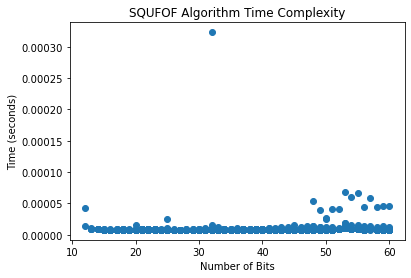

In [51]:
# Run the data collection
#collect_and_write_data()

# To plot data later from the file
plot_data_from_file('squfof_data.txt')

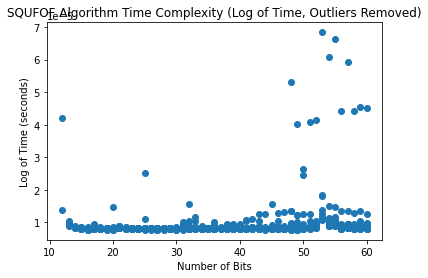

In [14]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_data_from_file(filename):
    bit_lengths = []
    log_times = []

    with open(filename, 'r') as file:
        for line in file:
            num_bits, elapsed_time = line.strip().split(', ')
            if float(elapsed_time) < 0.00030:
                bit_lengths.append(int(num_bits))
                log_times.append((float(elapsed_time)))

    if not log_times:  # Check if log_times is empty
        print("No data to plot.")
        return


    plt.scatter(bit_lengths, log_times)
    plt.title("SQUFOF Algorithm Time Complexity (Log of Time, Outliers Removed)")
    plt.xlabel("Number of Bits")
    plt.ylabel("Log of Time (seconds)")
    plt.show()

# Example usage
filename = 'squfof_data.txt'
plot_data_from_file(filename)


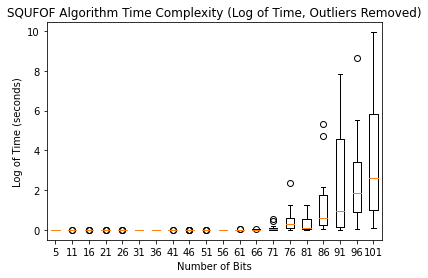

In [19]:
import matplotlib.pyplot as plt
import numpy as np
def plot_data_from_file(filename, num_boxplots):
    data_by_bit_lengths = {}  # Dictionary to store data grouped by bit lengths

    with open(filename, 'r') as file:
        for line in file:
            num_bits, elapsed_time = line.strip().split(', ')
            num_bits = int(num_bits)
            elapsed_time = float(elapsed_time)

            # Group data by number of bits
            if num_bits in data_by_bit_lengths:
                data_by_bit_lengths[num_bits].append(elapsed_time)
            else:
                data_by_bit_lengths[num_bits] = [elapsed_time]

    if not data_by_bit_lengths:
        print("No data to plot.")
        return

    # Sort the bit lengths and select a subset based on num_boxplots
    sorted_bit_lengths = sorted(data_by_bit_lengths.keys())
    step = len(sorted_bit_lengths) // num_boxplots
    selected_bit_lengths = sorted_bit_lengths[::step][:num_boxplots]

    # Extract data for selected bit lengths
    selected_data = [data_by_bit_lengths[bit_length] for bit_length in selected_bit_lengths]

    # Create boxplots
    plt.boxplot(selected_data, labels=selected_bit_lengths)
    plt.title("SQUFOF Algorithm Time Complexity (Log of Time, Outliers Removed)")
    plt.xlabel("Number of Bits")
    plt.ylabel("Log of Time (seconds)")
    plt.show()

# Example usage
filename = "random_squfof_data.txt"
num_boxplots = 20  # You can adjust this number as needed
plot_data_from_file(filename, num_boxplots)


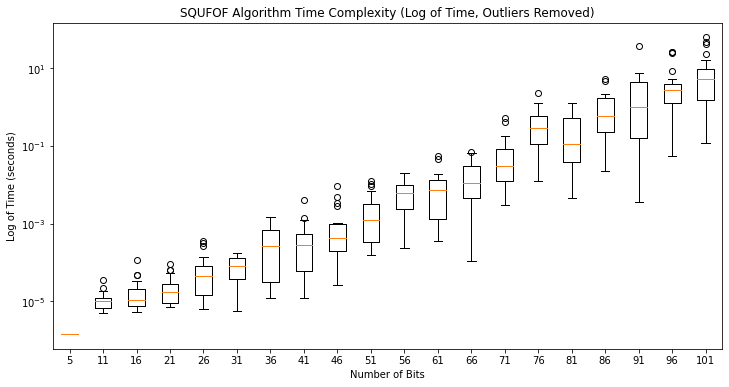

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data_from_file(filename, num_boxplots):
    data_by_bit_lengths = {}  # Dictionary to store data grouped by bit lengths

    with open(filename, 'r') as file:
        for line in file:
            num_bits, elapsed_time = line.strip().split(', ')
            num_bits = int(num_bits)
            elapsed_time = float(elapsed_time)

            # Group data by number of bits
            if num_bits in data_by_bit_lengths:
                data_by_bit_lengths[num_bits].append(elapsed_time)
            else:
                data_by_bit_lengths[num_bits] = [elapsed_time]

    if not data_by_bit_lengths:
        print("No data to plot.")
        return

    # Sort the bit lengths and select a subset based on num_boxplots
    sorted_bit_lengths = sorted(data_by_bit_lengths.keys())
    step = len(sorted_bit_lengths) // num_boxplots
    selected_bit_lengths = sorted_bit_lengths[::step][:num_boxplots]

    # Extract data for selected bit lengths
    selected_data = [data_by_bit_lengths[bit_length] for bit_length in selected_bit_lengths]

    # Create boxplots with a logarithmic scale
    plt.figure(figsize=(12, 6))  # Adjusting the figure size for better visibility
    plt.boxplot(selected_data, labels=selected_bit_lengths)
    plt.yscale('log')  # Set the Y-axis to a logarithmic scale
    plt.title("SQUFOF Algorithm Time Complexity (Log of Time, Outliers Removed)")
    plt.xlabel("Number of Bits")
    plt.ylabel("Log of Time (seconds)")
    plt.show()

# Example usage
filename = "random_squfof_data.txt"
num_boxplots = 20  # You can adjust this number as needed
plot_data_from_file(filename, num_boxplots)


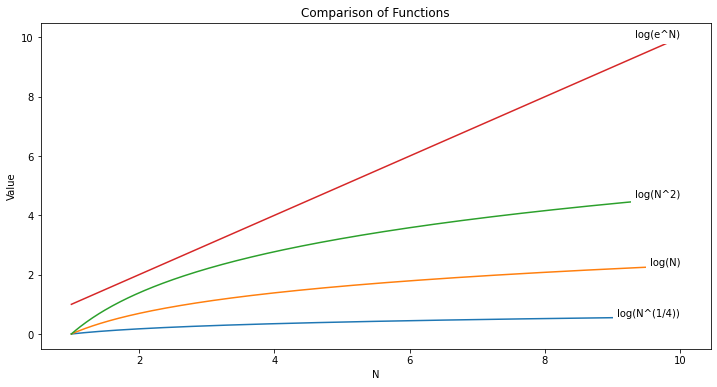

In [51]:
def plot_functions_with_labels_and_background():
    # Create an array of numbers (N) from 1 to 10
    N = np.linspace(1, 10, 400)

    # Calculate the values for each function
    log_N_quarter = np.log(N ** 0.25)
    N_values = np.log(N)
    N_squared = np.log((N ** 2))
    e_to_N = np.log(np.exp(N))

    # Plot each function with labels on the lines
    plt.figure(figsize=(12, 6))  # Adjusting the figure size for better visibility
    plt.plot(N, log_N_quarter, label='log(N^(1/4))')
    plt.text(10, log_N_quarter[-1], 'log(N^(1/4))', horizontalalignment='right', backgroundcolor='white')
    plt.plot(N, N_values, label='log(N)')
    plt.text(10, N_values[-1], 'log(N)', horizontalalignment='right', backgroundcolor='white')
    plt.plot(N, N_squared, label='log(N^2)')
    plt.text(10, N_squared[-1], 'log(N^2)', horizontalalignment='right', backgroundcolor='white')
    plt.plot(N, e_to_N, label='log(e^N)')
    plt.text(10, e_to_N[-1], 'log(e^N)', horizontalalignment='right', backgroundcolor='white')

    plt.xlabel('N')
    plt.ylabel('Value')
    plt.title('Comparison of Functions')

    # Display the plot
    plt.show()

# Call the function to plot with labels on the lines and background
plot_functions_with_labels_and_background()

